## This notebook will cover the following topics:

* Loading datasets from the Tensorflow Datasets API
* Creating an ImageDataGenerator to process images
* Performing image augmentation in memory to reduce overfitting
* Building deep convolutional neural networks from scratch
* Evaluating a model's performance
* Creating custom callbacks
* Using premade models with transfer learning

# Load Horses or Humans Dataset

We will load the `horses_or_humans` dataset from the Tensorflow Dataset API. Datasets loaded in this way are already processed in a way where they can be sent directly to a model. However, because images are rarely ever in such a nice format, we will save the images into folders to replicate real-world conditions.

In order to use the `ImageDataGenerator`, the images need to be organized in a specific folder organization (shown below).

                      Data                      <-----------------Root Directory 
                       /\
                      /  \
                     /    \
                    /      \
                   /        \
               Train        Test                <-----------------Data Subset Directory (train/val/test)
               /   \         /  \
              /     \       /    \
             /       \     /      \
        Horses   Humans  Horses   Humans        <-----------------Class Directory (name of data classes)

In [1]:
# import libraries
import tensorflow as tf
import tensorflow_datasets as tfds #Dataset API
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt #Data visualization
import os #Manipulate Files
from PIL import Image #Manipulate Images

import warnings
warnings.filterwarnings('ignore') #ignores warnings

#Make sure Tensorflow is version 2.0 or higher
print('Tensorflow Version:', tf.__version__)

/Users/mayank/opt/anaconda3/envs/deep_learning/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensorflow Version: 2.0.0


In [2]:
#Makes Folders to store images
os.makedirs('Data', exist_ok=True)
os.makedirs('Data/Train/Horses', exist_ok=True)
os.makedirs('Data/Train/Humans', exist_ok=True)
os.makedirs('Data/Test/Horses', exist_ok=True)
os.makedirs('Data/Test/Humans', exist_ok=True)

base_path = os.getcwd()
horse_counter = 0
human_counter = 0
#The below code will save the dataset images into the folders created above
#Note: This step is not required when using Tensorflow datasets but will be required when 
# using datasets that are in the wild or possibly on Kaggle
#see horse or humans doc here ->https://www.tensorflow.org/datasets/catalog/horses_or_humans
for i, dataset in enumerate(tfds.load('horses_or_humans', split=['train', 'test'])):
    if i==0: #training set
        set_path = os.path.join(base_path, 'Data/Train')
    else: #test set
        set_path = os.path.join(base_path, 'Data/Test')
        
    for row in list(dataset):
        im = Image.fromarray(row['image'].numpy())
        if row['label'] == 0: #0 is horse and 1 is human
            class_path = os.path.join(set_path, 'Horses')
            file_path = os.path.join(class_path, "horse_{}.jpeg".format(horse_counter))
            horse_counter += 1
        elif row['label'] == 1: #0 is horse and 1 is human
            class_path = os.path.join(set_path, 'Humans')
            file_path = os.path.join(class_path, "human_{}.jpeg".format(horse_counter))
            human_counter += 1
        im.save(file_path) #saves the image in the proper folder

2022-11-04 16:46:17.552017: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 16:46:17.552543: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


In [3]:
print('Number of Horse Images in the Training Set:', len(os.listdir('Data/Train/Horses')))
print('Number of Human Images in the Training Set:', len(os.listdir('Data/Train/Humans')))
print('\n')
print('Number of Horse Images in the Testing Set:', len(os.listdir('Data/Test/Horses')))
print('Number of Human Images in the Testing Set:', len(os.listdir('Data/Test/Humans')))

Number of Horse Images in the Training Set: 500
Number of Human Images in the Training Set: 435


Number of Horse Images in the Testing Set: 129
Number of Human Images in the Testing Set: 60


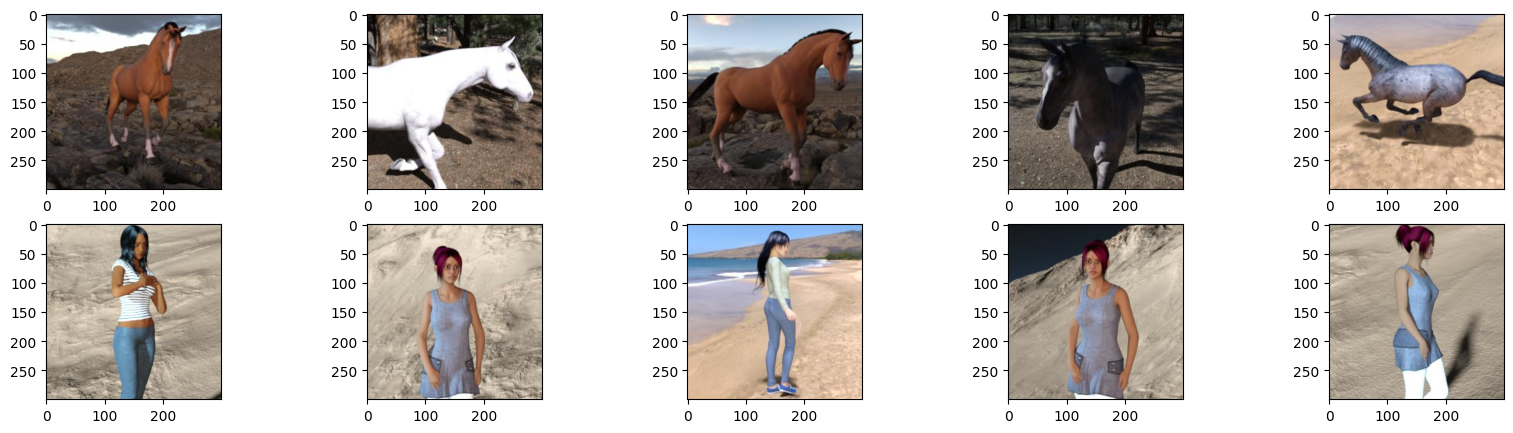

In [4]:
#Print Sample Images
horse_imgs = []
human_imgs = []

for i in range(5):
    horse_im = Image.open(os.path.join('Data/Train/Horses', os.listdir('Data/Train/Horses')[i]))
    human_im = Image.open(os.path.join('Data/Train/Humans', os.listdir('Data/Train/Humans')[i]))
    horse_imgs.append(horse_im)
    human_imgs.append(human_im)
    

plt.rcParams["figure.figsize"] = (20,5)
fig, axs = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        if i == 0:
            axs[i, j].imshow(horse_imgs[j])
        else:
            axs[i, j].imshow(human_imgs[j])
plt.show()

# `ImageDataGenerator` that Loads Images and Performs Image Augmentation

The `ImageDataGenerator` will be able automatically detect the different classes in our dataset from the folder structure that was setup in the previous section. The `ImageDataGenerator` will then take each of these images and apply transformations (such as rotations) as to augment our image dataset. After this, the data will be ready to be fed to a machine learning model.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Here we initialize an image generator that will conduct in-memory image augmentation
#see here for docs -> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
print('Training Set:')
train_gen = ImageDataGenerator(
    rescale=(1./255), #Rescales pixel values (originally 0-256) to 0-1
    rotation_range=0.4, #Rotates the image up to 40 degrees in either direction
    shear_range=0.2, #shears the image up to 20 degrees
    width_shift_range=0.2, #shifts the width by up to 20 %
    height_shift_range=0.2, #shifts the height by up to 20 %
    horizontal_flip=True, #flips the image along the horizontal axis
    fill_mode='nearest' #fills pixels lost during transformations with its nearest pixel
    )

train_generator = train_gen.flow_from_directory(
    'Data/Train',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

#Now we do the same thing for the test set but do not include any augmentations except for pixel rescaling
print('Testing Set:')
test_gen = ImageDataGenerator(rescale=(1./255))

test_generator = test_gen.flow_from_directory(
    'Data/Test',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

Training Set:
Found 935 images belonging to 2 classes.
Testing Set:
Found 189 images belonging to 2 classes.


In [6]:
from tensorflow.keras.callbacks import Callback

#creates a custom callback class
class CustomCallback(Callback):
    """
    This callback will stop the model from training once the model reaches 95% accuracy on the training data
    """
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print('Accuracy above 95% -- Stopping Training')
            self.model.stop_training = True #stops model training

my_callback = CustomCallback()

In [7]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def lr_update(epoch, lr):
    """
    For the first 5 epochs the learning rate will be 0.005.
    From epoch 6 and on, the learning rate will be reduced 1% per epoch
    """
    if epoch <= 5:
        return 0.005
    else:
        return lr * 0.99
    
lr_scheduler = LearningRateScheduler(lr_update)

## Creating Model

In [8]:
#Creates a model with the architecture mentioned above

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout


model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [9]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=20,
    callbacks=[my_callback, lr_scheduler])

Train for 30 steps
Epoch 1/20
30/30 [==============================] - 38s 1s/step - loss: 0.9598 - accuracy: 0.6364
Epoch 2/20
30/30 [==============================] - 37s 1s/step - loss: 0.5392 - accuracy: 0.7390
Epoch 3/20
30/30 [==============================] - 37s 1s/step - loss: 0.5069 - accuracy: 0.7551
Epoch 4/20
30/30 [==============================] - 37s 1s/step - loss: 0.5016 - accuracy: 0.7636
Epoch 5/20
30/30 [==============================] - 37s 1s/step - loss: 0.4010 - accuracy: 0.8332
Epoch 6/20
30/30 [==============================] - 37s 1s/step - loss: 0.3292 - accuracy: 0.8535
Epoch 7/20
30/30 [==============================] - 37s 1s/step - loss: 0.2784 - accuracy: 0.8834
Epoch 8/20
30/30 [==============================] - 37s 1s/step - loss: 0.3031 - accuracy: 0.8695
Epoch 9/20
30/30 [==============================] - 36s 1s/step - loss: 0.3014 - accuracy: 0.8738
Epoch 10/20
30/30 [==============================] - 37s 1s/step - loss: 0.2101 - accuracy: 0.9144


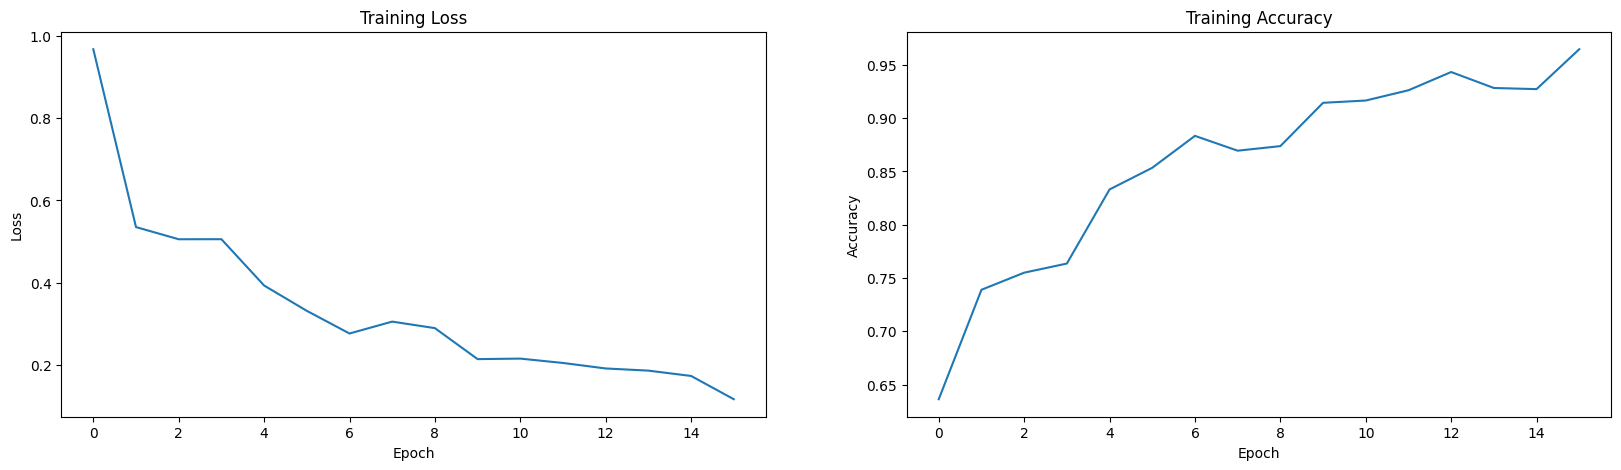

In [10]:
#Plots model training history

fig, axs = plt.subplots(1, 2)

axs[0].plot(history.history['loss'])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(history.history['accuracy'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy')

plt.show()

In [11]:
#Evaluate Custom CNN on Test Data
#We will now see how well our model performs on test data. 
#It is likely that the model is overfitting the training data.
test_acc = model.evaluate(test_generator, verbose=0)[1]
print('Model Accuracy on Test Data:', round(test_acc,3))

Model Accuracy on Test Data: 0.72
